In [38]:
from RHM2 import HierarchicalGrammar, encode_dataset, prepare_tensors, reconstruct_labels
import torch
import torch.nn as nn

In [39]:
rules = {
    'root_symbols': ['1', '2'],
    'terminal_symbols': ['i', 'j', 'k'],  # Symbols that don't appear on LHS of rules
    'rules': {
        # Level 1 rules
        '1': [('aa', 1.0), ('ab', 1.0), ('ac', 1.0), ('ad', 1.0)],
        '2': [('ba', 1.0), ('bb', 1.0), ('bc', 1.0), ('bd', 1.0)],
        
        # Level 2 rules
        'a': [ ('ef', 1.0), ('eg', 1.0), ('eh', 1.0)],
        'b': [('fe', 1.0), ('fg', 1.0), ('fh', 1.0)],
        'c': [('ge', 1.0), ('gf', 1.0), ('gh', 1.0)],
        'd': [('he', 1.0), ('hf', 1.0), ('hg', 1.0)],
        
        # Level 3 rules
        'e': [('ij', 1.0), ('ik', 1.0), ('il', 1.0)],
        'f': [('ji', 1.0), ('jk', 1.0), ('jl', 1.0)],
        'g': [('ki', 1.0), ('kl', 1.0), ('kl', 1.0)],
        'h': [('li', 1.0), ('lj', 1.0), ('lk', 1.0)],
    }
}

dim_vocabulary = 4
max_levels = 3
branching_rate = 2

In [40]:
rules = {
    'root_symbols': ['1', '2'],
    'terminal_symbols': ['g','i','h'],  # Symbols that don't appear on LHS of rules
    'rules': {
        # Level 1 rules
        '1': [('ab', 1.0), ('ac', 1.0)],
        '2': [('ba', 1.0), ('bc', 1.0)],
        
        # Level 2 rules
        'a': [('de', 1.0), ('df', 1.0)],
        'b': [('ed', 1.0), ('ef', 1.0)],
        'c': [('fd', 1.0), ('fe', 1.0)],
       
        # Level 3 rules
        'd': [('gi', 1.0), ('gh', 1.0)],
        'e': [('ig', 1.0), ('ih', 1.0)],
        'f': [('hg', 1.0), ('hi', 1.0)],
    }
}

dim_vocabulary = 3
max_levels = 3
branching_rate = 2

#Unique sequenes = 256 out of 6561 in a full tree, 3,9% of the full tree

In [41]:
grammar = HierarchicalGrammar(rules)

# Generate samples
samples = grammar.generate_dataset(256, max_depth=3)
print(samples.head())

# Get all possible leaf characters
leaf_chars = sorted(set(''.join(samples['sequence'])))
print("Leaf characters:", leaf_chars)
encoded_df = encode_dataset(samples, leaf_chars)

data, label = prepare_tensors(encoded_df)

  label  sequence
0     2  ighggihi
1     2  ighggiig
2     1  gihiihgi
3     2  ihhgghhi
4     1  ghhghigi
Leaf characters: ['g', 'h', 'i']


In [42]:
def unique_sequences(x: torch.Tensor, *, return_counts: bool = True):
    """
    x : (B, 1, d, n)  one-hot or probability tensor
        B = batch-size, d = vocab size, n = sequence length
    returns
        uniq   : (k, n)  int tensor  (k = #unique sequences)
        counts : (k,)    how often each sequence occurs  (optional)
    """
    # 1) collapse the singleton dim and turn probs → indices
    seq_idx = x.squeeze(1).argmax(dim=1)          # (B, n) int

    # 2) use torch.unique along rows
    uniq, counts = torch.unique(seq_idx, dim=0, return_counts=return_counts)

    return (uniq, counts) if return_counts else uniq

uniq, counts = unique_sequences(data)

print("unique sequences :", uniq.size(0))
print("first 5:")
for u, c in zip(uniq[:5], counts[:5]):
    print(u.tolist(), "→", c.item())


unique sequences : 162
first 5:
[0, 1, 1, 0, 1, 0, 0, 1] → 3
[0, 1, 1, 0, 1, 0, 0, 2] → 1
[0, 1, 1, 0, 1, 0, 2, 1] → 1
[0, 1, 1, 0, 1, 2, 0, 2] → 1
[0, 1, 1, 0, 1, 2, 2, 0] → 1


In [43]:
# rules = {
#     'root_symbols'   : ['1','2','3','4'],  # now 4 classes
#     'terminal_symbols': ['e',"f", "g", "h"],         # still 2 leaf tokens
#     'rules': {
#         # ─── level 1 ─── choose one of four roots
#         '1': [('aa',1.0), ('ab',1.0)],
#         '2': [('ba',1.0), ('bb',1.0)],
#         '3': [('cd',1.0), ('dc',1.0)],
#         '4': [('dc',1.0), ('dd',1.0)],

#         # ─── level 2 ─── expand a/b/c/d
#         'a': [('ee',1.0), ('ef',1.0)],
#         'b': [('fe',1.0), ('ff',1.0)],
#         'c': [('gg',1.0), ('gh',1.0)],  # mixing in i/j leaves
#         'd': [('hg',1.0), ('hh',1.0)],

#         # ─── level 3 ─── terminal level: map c/d→i/j
#         'e': [('ii',1.0), ('ij',1.0)],
#         'f': [('ji',1.0), ('jj',1.0)],
#         'g': [('kk',1.0), ('kl',1.0)],
#         'h': [('lk',1.0), ('ll',1.0)],
#     }
# }


In [44]:
import torch
import torch.nn.functional as F

# ------------------------------------------------------------
# build the (d × d) legality matrix once
# ------------------------------------------------------------
def build_allowed_matrix(prod_rules, leaf_alphabet):
    """
    prod_rules   : dict mapping parent_symbol -> list of (expansion_str, weight)
    leaf_alphabet: list of single‐char terminal symbols, e.g. ['i','j','k','l']
    returns a (d×d) bool Tensor `allowed` where allowed[l,r]=True iff the pair
    (leaf_alphabet[l], leaf_alphabet[r]) is legal in your grammar.
    """
    d = len(leaf_alphabet)
    char2idx = {c: i for i, c in enumerate(leaf_alphabet)}

    allowed = torch.zeros(d, d, dtype=torch.bool)
    for parent, exp_list in prod_rules.items():
        for exp_str, _ in exp_list:
            # exp_str should be length‐2, e.g. "ij", "hl", etc.
            if len(exp_str) != 2:
                continue
            c1, c2 = exp_str[0], exp_str[1]
            if c1 in char2idx and c2 in char2idx:
                allowed[char2idx[c1], char2idx[c2]] = True

    return allowed

# ------------------------------------------------------------
# masked log-softmax that **re-normalises** per position
# ------------------------------------------------------------




## COSINE SCHEDULE TRIAL


In [45]:
import torch
import numpy as np

class DiffusionProcess():
    def __init__(self, noise_scale=1, max_time=10.0, mode = "exp"):
        """
        Proper cosine-based noise schedule without oscillation.
        Args:
            noise_scale: how much gaussian noise to inject
            max_time: upper bound for timestep t
        """
        self.noise_scale = noise_scale
        self.max_time = max_time
        self.mode = mode

    def alpha_bar(self, t):
        """
        Monotonic decay from 1 → 0 using half-cosine on domain [0, π/2].
        Maps t ∈ [0, max_time] to θ ∈ [0, π/2]
        """
        t = torch.tensor(t, dtype=torch.float32) if not isinstance(t, torch.Tensor) else t
        theta = (t / self.max_time) * (np.pi / 2)
        return torch.cos(theta).pow(2)

    def add_noise(self, one_hot_matrix, t):
        # assume `t` is either a float or a shape-(B,1) Tensor on the same device as `one_hot_matrix`
        if self.mode == "exp":
            if not isinstance(t, torch.Tensor):
                t = torch.tensor([[t]], dtype=torch.float32, device=one_hot_matrix.device)
            elif t.ndim == 1:
                t = t.unsqueeze(1)
            t = t.to(one_hot_matrix.device)

            # Compute ᾱ(t) = exp(−0.5·t)
            alpha_bar_t = torch.exp(-0.5 * t)                   # shape = (B,1)
            alpha_t     = torch.sqrt(alpha_bar_t).view(-1,1,1,1) # broadcast to (B,1,1,1)
            beta_t      = torch.sqrt(1.0 - alpha_bar_t).view(-1,1,1,1)

            noise = torch.randn_like(one_hot_matrix)  # standard normal of shape (B,1,d,n)
            return alpha_t * one_hot_matrix + beta_t * noise

        
        elif self.mode == "cos":
            B, _, d, n = one_hot_matrix.shape

            if not isinstance(t, torch.Tensor):
                t = torch.tensor([[t]], dtype=torch.float32, device=one_hot_matrix.device)
            elif t.ndim == 1:
                t = t.unsqueeze(1)
            t = t.to(one_hot_matrix.device)


            alpha_bar_t = self.alpha_bar(t).view(-1, 1, 1, 1).to(one_hot_matrix.device)
            alpha_t = torch.sqrt(alpha_bar_t)
            beta_t = torch.sqrt(1.0 - alpha_bar_t)

            noise = torch.randn_like(one_hot_matrix) * self.noise_scale
            return alpha_t * one_hot_matrix + beta_t * noise

In [46]:
def generate_diffusion_dataset(data, labels, diffusion_process, time_distribution='uniform', max_time=1):
    """
    Generates a dataset by applying the diffusion process to input data at random timesteps.

    Parameters:
    - data: Tensor of shape (batch_size, 1, d, n), the original clean data.
    - labels: Corresponding labels for each data sample.
    - diffusion_process: An instance of DiffusionProcess.
    - time_distribution: 'uniform' or 'gaussian' (defines how timesteps are sampled).
    - max_time: Maximum timestep for diffusion.

    Returns:
    - noisy_data: Tensor of shape (batch_size, 1, d, n), noised data.
    - timesteps: Tensor of shape (batch_size, 1, 1), corresponding timesteps.
    - clean_data: Tensor of shape (batch_size, 1, d, n), original clean data.
    - labels: Expanded labels matching noisy_data.
    """

    data = data.squeeze(1)  # Convert (batch_size, 1, d, n) -> (batch_size, d, n) 
    batch_size, d, n = data.shape

    noisy_data_list = []
    timesteps_list = []
    expanded_labels_list = []

    for i in range(batch_size):
        # Sample a time step
        if time_distribution == 'uniform':
            t = np.random.uniform(0, max_time)
        elif time_distribution == 'gaussian':
            t = np.clip(np.random.normal(loc=max_time / 4, scale=max_time/2), 0, max_time)
        else:
            raise ValueError("Invalid time_distribution. Choose 'uniform' or 'gaussian'.")

        t_tensor = torch.tensor([[t]], dtype=torch.float32)  # Shape (1, 1)

        noised_sample = diffusion_process.add_noise(data[i].unsqueeze(0).unsqueeze(0), t)  # (1, 1, d, n)

        # Store results
        noisy_data_list.append(noised_sample)
        timesteps_list.append(t_tensor)  # (1, 1)
        expanded_labels_list.append(labels[i].unsqueeze(0) if isinstance(labels, torch.Tensor) else torch.tensor([labels[i]]))  # Ensure tensor format

    # Stack all samples into tensors
    noisy_data = torch.cat(noisy_data_list, dim=0)  # (batch_size, 1, d, n)
    timesteps = torch.cat(timesteps_list, dim=0)  # (batch_size, 1, 1)
    expanded_labels = torch.cat(expanded_labels_list, dim=0)  # (batch_size, ...)

    timesteps /= max_time  # Normalize timesteps to [0, 1]

    return noisy_data, timesteps, expanded_labels


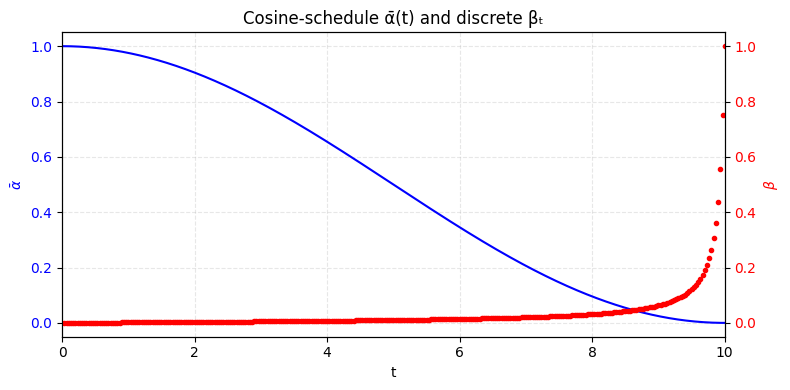

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_schedule(diffusion, T_rd=300):
    device = torch.device("cpu")
    # continuous t for forward
    t_cont = torch.linspace(0.0, diffusion.max_time, 1000, device=device)
    a_bar_cont = diffusion.alpha_bar(t_cont)           # ᾱ(t) continuous
    # discrete grid for backward
    t_disc = torch.linspace(0.0, diffusion.max_time, T_rd+1, device=device)
    a_bar_disc = diffusion.alpha_bar(t_disc)           # ᾱ(j)
    a_bar_prev = torch.cat([a_bar_disc[:1], a_bar_disc[:-1]])
    beta_disc = (1 - a_bar_disc / a_bar_prev).clamp(min=0, max=1)

    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(t_cont.numpy(), a_bar_cont.numpy(), 'b-', label=r"$\bar\alpha(t)$")
    ax1.set_xlabel("t")
    ax1.set_ylabel(r"$\bar\alpha$", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title("Cosine‐schedule ᾱ(t) and discrete βₜ")

    ax2 = ax1.twinx()
    ax2.plot(t_disc[1:].numpy(), beta_disc[1:].numpy(), 'r.', label=r"$\beta_j$")
    ax2.set_ylabel(r"$\beta$", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # mark the backward grid on the x‐axis
    ax1.set_xlim(0, diffusion.max_time)
    ax1.grid(True, linestyle='--', alpha=0.3)
    fig.tight_layout()
    plt.show()


# assuming your DiffusionProcess is already defined and imported:
diffusion = DiffusionProcess(mode="cos", max_time=10.0, noise_scale=0.3)
plot_schedule(diffusion, T_rd=300)


In [48]:
# Generate the dataset
diffusion = DiffusionProcess(mode = "cos", noise_scale=0.3)
noisy_data, timesteps, labels = generate_diffusion_dataset(data, label, diffusion, time_distribution='uniform', max_time=10)


In [49]:

import numpy as np

if False:

    np.save("data.npy",  data.detach().cpu().numpy())
    np.save("noisy_data.npy",  noisy_data.detach().cpu().numpy())
    np.save("timesteps.npy",   timesteps.detach().cpu().numpy())
    np.save("labels.npy",      labels.detach().cpu().numpy())
else:
    data = torch.from_numpy(np.load("/Users/tommasoaiello/Desktop/TesiVS/2Label3Layer4Dim2Rate/data.npy"))
    noisy_data  = torch.from_numpy(np.load("/Users/tommasoaiello/Desktop/TesiVS/2Label3Layer4Dim2Rate/noisy_data.npy"))
    timesteps   = torch.from_numpy(np.load("/Users/tommasoaiello/Desktop/TesiVS/2Label3Layer4Dim2Rate/timesteps.npy"))
    labels      = torch.from_numpy(np.load("/Users/tommasoaiello/Desktop/TesiVS/2Label3Layer4Dim2Rate/labels.npy"))

n = noisy_data.shape[0]

idx = torch.randperm(n)

data = data[idx]
noisy_data = noisy_data[idx]
timesteps = timesteps[idx]
labels = labels[idx]


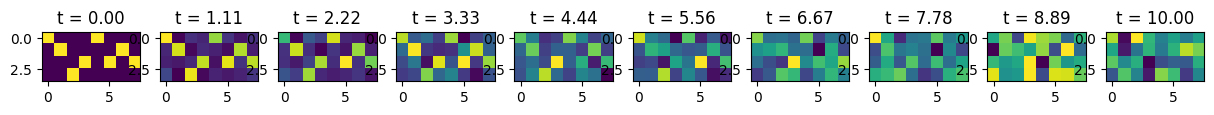

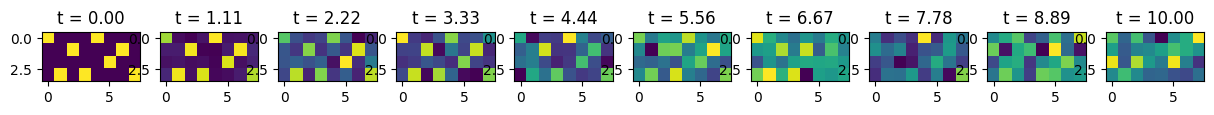

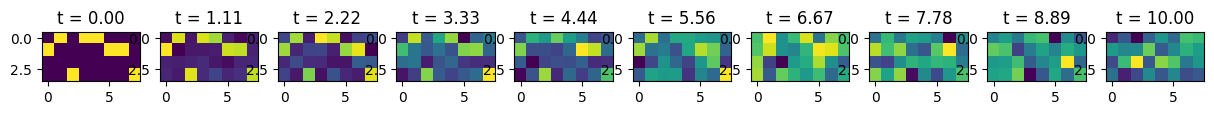

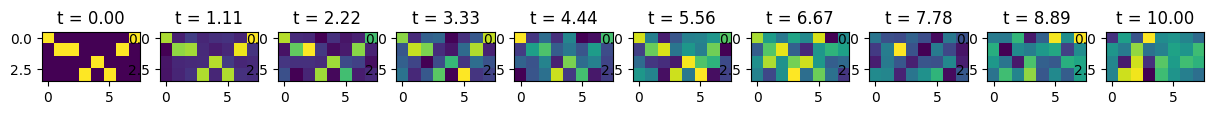

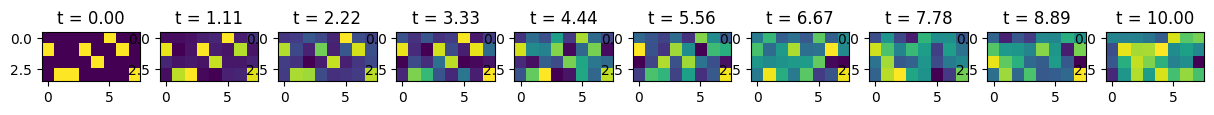

In [50]:
import matplotlib.pyplot as plt

def visualize_noised_data(data, diffusion_process, max_time=10, num_samples=10):
    
    for j in range(5):
        plt.figure(figsize=(15, 5))
        for i in range(num_samples):
            t = i * (max_time / (num_samples - 1))
            noised_sample = diffusion_process.add_noise(data[50+j].unsqueeze(0), t)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(noised_sample.squeeze().numpy(), cmap="viridis")
            plt.title(f"t = {t:.2f}")
        plt.show()

visualize_noised_data(data, diffusion)

In [51]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=8):
        super().__init__()
        self.embed_dim = embed_dim
        self.encoding = torch.zeros(max_len, embed_dim - 1)  # Only for embed_dim - 1
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim - 1, 2).float() * (-math.log(10000.0) / (embed_dim - 1)))

        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term[: (embed_dim - 1) // 2])
        self.encoding = self.encoding.unsqueeze(0)  # (1, max_len, embed_dim-1)

    def forward(self, x, timesteps):
        """
        x: Tensor of shape (batch_size, seq_len, embed_dim-1)
        timesteps: Tensor of shape (batch_size, 1), values in range [0, 1]
        """
        batch_size, seq_len, _ = x.shape
        pe = self.encoding[:, :seq_len, :].to(x.device) * 0.5  # Ensure it’s on the correct device

        timesteps = timesteps.unsqueeze(1).expand(batch_size, seq_len, 1)  # Expand to match sequence length

        return torch.cat([x + pe, timesteps], dim=-1)  # Concatenate along embedding dimension

In [52]:
import math
# clean_data : (N, 1, d, n)
X = data.squeeze(1).float().reshape(data.size(0), -1).clone()   # (N,D)

# centre
μ = X.mean(dim=0, keepdim=True)
X -= μ

# scale so each coordinate has variance 1
σ = X.std(dim=0, keepdim=True) + 1e-8      # avoid /0
X /= σ                                     # now Var[X_i]=1

# --- power iteration for top eigen-value -------------------------
N, D = X.shape
v = torch.randn(D, 1, device=X.device)
for _ in range(40):
    v = X.T @ (X @ v) / N                  # (XᵀX/N) v   == correlation·v
    v = v / v.norm()

Λ = (v.T @ (X.T @ (X @ v)) / N).item()     # ≈ λ_max ≥ 1
t_S = 0.5 * math.log(Λ)
print(f"Λ = {Λ:.3f}   →   t_S = {t_S:.4f}")


Λ = 3.217   →   t_S = 0.5842


In [53]:
# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),  # Add dropout
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout(attn_output)  # Add dropout to residual connection
        x = self.norm1(x)
        ff_output = self.ffn(x)
        x = x + self.dropout(ff_output)  # Add dropout to residual connection
        x = self.norm2(x)
        return x
    
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, ff_dim, n, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim * n, ff_dim)  # First hidden layer
        self.fc2 = nn.Linear(ff_dim, num_classes)  # Output layer
        self.relu = nn.GELU()
        self.softmax = nn.Softmax(dim=-1)  # Apply softmax for classification

    def forward(self, x):
        x = x.flatten(start_dim=1)  # Flatten sequence dimension
        x = self.fc1(x)  # Pass through first linear layer
        x = self.relu(x)  # Activation function
        x = self.fc2(x)  # Output layer
        return self.softmax(x)  # Apply softmax

class TransformerDenoiser_for_classification(nn.Module):
    def __init__(self, d, n, embed_dim=128, num_heads=4, ff_dim=256):
        super().__init__()
        self.embedding = nn.Linear(d, embed_dim-1)  # Encode (d) → (128 -1 = 12 !!!!!!CAREFUL ABOUT THE -1
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=n)   # Positional Encoding along `n`
        self.encoder = TransformerEncoder(embed_dim, num_heads, ff_dim)  
        self.decoder = TransformerDecoder(embed_dim, num_heads, ff_dim)
        self.classifier = ClassificationHead(embed_dim, ff_dim, n, 2)#add number labels)

    def forward(self, x, t):
        print(x.shape,t.shape)
        x = x.squeeze(1).transpose(1, 2)  # (batch_size, 1, d, n) → (batch_size, n, d)
        print(x.shape)
        x = self.embedding(x)  # (batch_size, n, 128 - 1 = 127)
        print(x.shape, "first embedding")
        x = self.pos_encoder(x, t)  # Add positional encoding along `n`
        print(x.shape, "after positional encoding")
        print(x[0])
        encoded = self.encoder(x)
        print(x.shape)
        logits = self.classifier(encoded)  # (batch_size, num_classes)
        return logits  # (batch_size, n, d) 

def train_for_classification(model, noisy_data, labels, timesteps, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    print(model, noisy_data.shape, timesteps.shape, labels.shape)

    for epoch in range(epochs):
        optimizer.zero_grad()

        predictions = model(noisy_data, timesteps)  # (batch_size, num_classes)
    
        loss = loss_fn(predictions, labels)
        print(loss)

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [54]:
from torch.optim.lr_scheduler import ExponentialLR
# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),  # Add dropout
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout(attn_output)  # Add dropout to residual connection
        x = self.norm1(x)
        ff_output = self.ffn(x)
        x = x + self.dropout(ff_output)  # Add dropout to residual connection
        x = self.norm2(x)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=dropout)
        self.cross_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),  # Replace ReLU with GELU
            nn.Dropout(dropout),  # Add dropout
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory):
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout(attn_output)  # Add dropout to residual connection
        x = self.norm1(x)
        cross_attn_output, _ = self.cross_attention(x, memory, memory)
        x = x + self.dropout(cross_attn_output)  # Add dropout to residual connection
        x = self.norm2(x)
        ff_output = self.ffn(x)
        x = x + self.dropout(ff_output)  # Add dropout to residual connection
        x = self.norm3(x)
        return x
    
class TransformerDenoiser_for_denoise(nn.Module):
    def __init__(self, d, n, embed_dim=128, num_heads=8, ff_dim=512, num_encoders=3, num_decoders=3, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(d, embed_dim - 1)  # Embed input features
        self.dropout = nn.Dropout(dropout)  # Add dropout
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=n)   # Add positional encoding

        # Encoders
        self.encoders = nn.ModuleList([
            TransformerEncoder(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_encoders)
        ])

        # Decoders
        self.decoders = nn.ModuleList([
            TransformerDecoder(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_decoders)
        ])

        # Output layer
        self.output_layer = nn.Linear(embed_dim, d)  # Map back to original feature size

    def forward(self, x, t):
        # Reshape and embed input
        x = x.squeeze(1).transpose(1, 2)  # (batch_size, n, d)
        x = self.embedding(x)  # (batch_size, n, embed_dim - 1)
        x = self.dropout(x)  # Apply dropout
        x = self.pos_encoder(x, t)  # Add positional encoding

        # Pass through encoders
        for encoder in self.encoders:
            x = encoder(x)  # (batch_size, n, embed_dim)

        # Store encoder output as memory
        memory = x

        # Pass through decoders
        for decoder in self.decoders:
            x = decoder(x, memory)  # (batch_size, n, embed_dim)

        # Output layer
        output = self.output_layer(x)  # (batch_size, n, d)

        # Reshape output to match input shape
        return output.transpose(1, 2).unsqueeze(1)  # (batch_size, 1, d, n)

In [55]:
def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier uniform initialization
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Initialize biases to zero
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)  # Initialize LayerNorm weights to 1
        nn.init.zeros_(m.bias)  # Initialize LayerNorm biases to 0

d = dim_vocabulary  # Number of terminal symbols
n = branching_rate ** max_levels  # Number of leaf nodes (2^max_levels for binary trees)

# Apply Xavier initialization to your model
model = TransformerDenoiser_for_denoise(
    d = d,          # matches data channels
    n = n,          # matches leaf count
    embed_dim=128,
    num_heads=8,
    ff_dim=512,
    num_encoders=3,
    num_decoders=3,
    dropout=0.1, 
)
model.apply(init_weights_xavier)

TransformerDenoiser_for_denoise(
  (embedding): Linear(in_features=3, out_features=127, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (pos_encoder): PositionalEncoding()
  (encoders): ModuleList(
    (0-2): 3 x TransformerEncoder(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoders): ModuleList(
    (0-2): 3 x TransformerDecoder(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_

In [56]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# helper from your snippet (kept verbatim)
# ------------------------------------------------------------
def build_inverse_map(prod_rules):
    inv = {}
    for parent, exp_list in prod_rules.items():
        for exp_str, _ in exp_list:
            if len(exp_str) == 2:
                inv[(exp_str[0], exp_str[1])] = parent
    return inv

def tensor_to_string(mat, index_to_char):
    idxs = mat.argmax(dim=0)
    return ''.join(index_to_char[int(i)] for i in idxs)

def recover_root(seq, inv_map, branching_rate=2):
    level = list(seq)
    while len(level) > 1:
        nxt = []
        for i in range(0, len(level), branching_rate):
            pair = (level[i], level[i + 1])
            parent = inv_map.get(pair)
            if parent is None:
                return 0
            nxt.append(parent)
        level = nxt
    return int(level[0])

def predict_labels(batch_logits, leaf_chars, prod_rules, branching_rate=2):
    inv_map = build_inverse_map(prod_rules)
    idx2char = {i: c for i, c in enumerate(leaf_chars)}

    B, _, _, _ = batch_logits.shape
    preds = []
    for b in range(B):
        mat = batch_logits[b, 0]                 # (d, n)
        seq = tensor_to_string(mat, idx2char)
        preds.append(recover_root(seq, inv_map, branching_rate))
    return torch.tensor(preds, dtype=torch.long)

# ------------------------------------------------------------
# bucket-accuracy helper (gpu-safe)
# ------------------------------------------------------------
_EDGES = torch.linspace(0.0, 1.0, 11)
def bin_accuracy(preds, labels, timesteps):
    edges = _EDGES.to(timesteps.device)
    idx   = torch.bucketize(timesteps.view(-1), edges, right=False) - 1
    acc   = torch.zeros(10, device=timesteps.device)     # ← init to 0
    for b in range(10):
        m = idx == b
        if m.any():
            acc[b] = (preds[m] == labels[m]).float().mean()
        # else keep 0.0
    return acc.cpu()


# ------------------------------------------------------------------
# fancy ribbon plot
# ------------------------------------------------------------------
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl

def plot_evolution_fancy(A, *, title="evolution of allowed-sequence accuracy"):
    """
    A : (E, 10)  numpy / tensor  – accuracy per epoch (E) and bucket (10)
    """
    A = np.asarray(A)
    E, B = A.shape
    x = np.linspace(0.05, 0.95, B)             # bucket mid-points

    # ---- styling ----------------------------------------------------------
    FIG_BG, AX_BG = "#f7f5f2", "#faf9f6"
    mpl.rcParams.update({
        "axes.facecolor": AX_BG,  "figure.facecolor": FIG_BG,
        "axes.edgecolor": "black","axes.linewidth": 1.2,
        "grid.linestyle": ":",    "grid.linewidth": 0.8,
        "grid.alpha": 0.5,
    })

    cmap   = plt.get_cmap("plasma", E)
    norm   = mpl.colors.Normalize(0, E-1)
    sm     = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])

    fig, ax = plt.subplots(figsize=(8,5))
    for e in range(E):
        y = np.ma.masked_invalid(A[e])         # hide NaNs so lines don’t break
        ax.plot(x, y, marker="o", lw=2.5, color=cmap(e))

    ax.set(xlim=(0,1), ylim=(0,1.02),
           xlabel="t / T  (bucket mid-point)",
           ylabel="accuracy (non-zero labels)",
           title=title)
    ax.grid(axis="y")

    for side in ("top","right"):
        ax.spines[side].set_visible(False)

    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("epoch", rotation=270, labelpad=12)

    fig.tight_layout(); plt.show()



In [57]:
@torch.no_grad()
def reverse_diffusion(model, x_T, t_norm, diffusion, *, T=300):
    device = x_T.device
    # 1) build schedule
    t_grid     = torch.linspace(0, diffusion.max_time, T+1, device=device)
    ᾱ         = diffusion.alpha_bar(t_grid)          # (T+1,)
    ᾱ_prev    = torch.cat([torch.ones(1,device=device), ᾱ[:-1]])
    β          = (1 - ᾱ[1:] / ᾱ_prev[:-1]).clamp(max=0.999)  # (T,)

    # 2) map each sample’s t to an integer step
    steps = (t_norm.view(-1) * T).long().clamp(max=T)

    x = x_T.clone()
    for b, start in enumerate(steps):
        for j in range(start, 0, -1):
            ā_j   = ᾱ[j]
            ā_jm1 = ᾱ_prev[j]
            β_j    = β[j-1]
            α_j    = 1 - β_j

            # predict p0
            t_in = torch.tensor([[j / T]], device=device)
            logits = model(x[b:b+1], t_in)
            p0 = F.softmax(logits, dim=2)

            # compute mean
            coef1 = torch.sqrt(ā_jm1)
            coef2 = (1 - ā_jm1) / torch.sqrt(1 - ā_j)
            μ = coef1 * p0 + coef2 * x[b:b+1]

            # add noise (scaled by your noise_scale)
            if j > 1:
                noise = torch.randn_like(μ) * torch.sqrt(β_j) * diffusion.noise_scale
                x[b:b+1] = μ + noise
            else:
                x[b:b+1] = μ

    return x


In [58]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_evolution_fancy(A, t_S, *, title="evolution of allowed-sequence accuracy"):
    """
    A   : (E, 20) numpy array – accuracy per epoch (E) and bucket (20)
    t_S : float           – speciation time (in the same 0–1 t/T scale)
    """
    A = np.asarray(A)
    E, B = A.shape
    x = np.linspace(0.025, 0.975, B)  # bucket midpoints for 0.05 intervals

    # ---- styling ----------------------------------------------------------
    FIG_BG, AX_BG = "#f7f5f2", "#faf9f6"
    mpl.rcParams.update({
        "axes.facecolor": AX_BG,  "figure.facecolor": FIG_BG,
        "axes.edgecolor": "black","axes.linewidth": 1.2,
        "grid.linestyle": ":",    "grid.linewidth": 0.8,
        "grid.alpha": 0.5,
    })

    cmap = plt.get_cmap("plasma", E)
    norm = mpl.colors.Normalize(0, E-1)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    fig, ax = plt.subplots(figsize=(10,6))
    for e in range(E):
        y = np.ma.masked_invalid(A[e])
        ax.plot(x, y, marker="o", lw=2.0, markersize=5, color=cmap(e))

    # add speciation time line
    ax.axvline(x=t_S, linestyle="--", linewidth=2, label="speciation time")

    ax.set(
        xlim=(0,1), ylim=(0,1.02),
        xlabel="t / T  (0.05 interval buckets)",
        ylabel="accuracy (non-zero labels)",
        title=title
    )
    ax.grid(axis="y")

    # remove top/right spines
    for side in ("top","right"):
        ax.spines[side].set_visible(False)

    # add legend for the speciation-time line
    ax.legend(loc="upper left")

    # colorbar for epochs
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("epoch", rotation=270, labelpad=12)

    fig.tight_layout()
    plt.show()


In [59]:
def plot_illegal_evolution(illegal_probs, timestep_buckets, T_rd):
    import matplotlib.pyplot as plt
    import numpy as np

    # prepare data: epochs x buckets
    epochs = [ep for ep, _ in illegal_probs]
    bucket_midpoints = [((timestep_buckets[i] + timestep_buckets[i+1]) / 2) 
                        for i in range(len(timestep_buckets) - 1)]
    data = np.array([prob for _, prob in illegal_probs])  # shape = (n_epochs, n_buckets)

    # manually set a white background and light grid
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_facecolor("white")
    ax.grid(True, color="#dddddd", linestyle="-", linewidth=1, alpha=0.3)

    # create a ScalarMappable so we can have a colorbar that goes from min(epoch)→max(epoch)
    cmap = plt.cm.plasma
    norm = plt.Normalize(vmin=min(epochs), vmax=max(epochs))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # only needed for colorbar

    # plot each epoch’s accuracy curve (accuracy = 1 - illegal_prob)
    for i, epoch in enumerate(epochs):
        y = 1 - data[i]  # accuracy per bucket
        color = sm.to_rgba(epoch)
        ax.plot(
            bucket_midpoints,
            y,
            marker="o",
            markersize=5,
            linewidth=2,
            color=color,
            alpha=0.8,
            label=f"ep {epoch}"
        )

    # labels & title (all lowercase to match art style)
    ax.set_xlabel("t / T (bucket mid-point)", fontsize=12)
    ax.set_ylabel("accuracy (non-zero labels)", fontsize=12)
    ax.set_title("evolution of allowed-sequence accuracy", fontsize=14)

    # add the vertical colorbar on the right
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("epoch", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()


In [60]:
import torch, matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau, CosineAnnealingLR

def train_unmasked(
    model,
    clean, noisy, timesteps, labels,
    *,
    leaf_chars, rules, diffusion,
    T_rd: int       = 300,
    epochs: int     = 400,
    batch_size: int = 128,
    test_size: float= 0.1,
    lr: float       = 2e-3,
    warmup_steps: int = 400,
    eval_every: int   = 30,
    patience: int     = 100,
    min_delta: float  = 5e-4,
    device: str | None = None,
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # split --------------------------------------------------------
    idx = torch.randperm(len(noisy))
    cut = int(len(noisy) * (1 - test_size))
    tr_ds = TensorDataset(noisy[idx[:cut]],  clean[idx[:cut]],
                          timesteps[idx[:cut]], labels[idx[:cut]])
    te_ds = TensorDataset(noisy[idx[cut:]],   clean[idx[cut:]],
                          timesteps[idx[cut:]], labels[idx[cut:]])
    tr_loader = DataLoader(tr_ds, batch_size, shuffle=True, drop_last=True)
    te_loader = DataLoader(te_ds, batch_size)

    # optimiser & schedulers --------------------------------------
    opt = AdamW(model.parameters(), lr=lr, weight_decay=0)
    #warmup = LambdaLR(opt, lambda s: (128**-0.5) *
                     #min((s+1)**-0.5, (s+1)*warmup_steps**-1.5))
    plateau = ReduceLROnPlateau(opt, mode="min", factor=0.5,
                                patience=5, threshold=min_delta)
    #cosine scheduler
    scheduler = CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-6)

    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.0)
    model.to(device)

    train_curve, val_curve, acc_log, acc_log2 = [], [], [], []
    best_val, bad_epochs = float("inf"), 0

    for epoch in range(1, epochs + 1):
        # ---------- train ---------------------------------------
        model.train(); run = 0.0
        for x_noisy, y_clean, t, _ in tr_loader:
            x_noisy, y_clean, t = [z.to(device) for z in (x_noisy, y_clean, t)]
            opt.zero_grad()
            logits = model(x_noisy, t).squeeze(1).transpose(1,2)
            tgt    = y_clean.squeeze(1).argmax(1)
            loss   = loss_fn(logits.reshape(-1, logits.size(-1)),
                             tgt.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step(); run += loss.item()
        train_curve.append(run / len(tr_loader))

        # ---------- val ----------------------------------------
        model.eval(); val = 0.0
        with torch.inference_mode():
            for x_noisy, y_clean, t, _ in te_loader:
                x_noisy, y_clean, t = [z.to(device) for z in (x_noisy, y_clean, t)]
                logits = model(x_noisy, t).squeeze(1).transpose(1,2)
                tgt    = y_clean.squeeze(1).argmax(1)
                val   += loss_fn(logits.reshape(-1, logits.size(-1)),
                                 tgt.reshape(-1)).item()
        val_ce = val / len(te_loader); val_curve.append(val_ce)
        scheduler.step()  # update learning rate
        #plateau.step(val_ce)

        print(f"ep {epoch:03d} | train {train_curve[-1]:.4f} | "
              f"val {val_ce:.4f} | lr {opt.param_groups[0]['lr']:.2e}")

        # ---------- reverse-diff eval every N -------------------
        if epoch % eval_every == 0:
            model.eval()
            bucket_preds, bucket_pred2 = [], []
            with torch.inference_mode():
                for x_noisy, _, t, lbl in te_loader:
                    x_noisy, t = x_noisy.to(device), t.to(device)
                    x0_hat = reverse_diffusion(model, x_noisy, t, diffusion, T=T_rd)
                    pred   = predict_labels(x0_hat.cpu(), leaf_chars, rules, branching_rate = branching_rate)   # (b,)
                    valid  = pred > 0
                    if valid.any():
                        bucket_preds.append( bin_accuracy(
                            pred[valid],
                            lbl[valid],           # gold already 1/2
                            t.cpu().view(-1)[valid]
                        ))
                    valid = (pred == lbl)
                    if valid.any():
                        bucket_pred2.append( bin_accuracy(
                            pred[valid],
                            lbl[valid],           # gold already 1/2
                            t.cpu().view(-1)[valid]
                        ))
            if bucket_preds:
                acc_log.append(torch.stack(bucket_preds).mean(0))  # mean over batches
            if bucket_pred2:
                acc_log2.append(torch.stack(bucket_pred2).mean(0))

        # ---------- early stop ---------------------------------
        if val_ce < best_val - min_delta:
            best_val = val_ce; bad_epochs = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print("early stopping 🚦"); break

    # -------- plots --------------------------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_curve, label="train CE")
    plt.plot(val_curve,   label="val  CE")
    plt.xlabel("epoch"); plt.ylabel("cross-entropy")
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    if acc_log:
        plot_evolution_fancy(torch.stack(acc_log), t_S=t_S,)
    if acc_log2:
        plot_evolution_fancy(torch.stack(acc_log2), t_S=t_S, title="Percentage of correctly reconstucted labels")

    return train_curve, val_curve

In [61]:
train = True
train_curve, val_curve = [], []


In [62]:
if train:
    t, v = train_unmasked(
        model,
        data,                # clean
        noisy_data,                # noisy
        timesteps=timesteps,            # timesteps
        labels=labels,               # labels
        leaf_chars=rules["terminal_symbols"],
        rules=rules["rules"],
        diffusion=diffusion,
        T_rd=300,
        epochs=1,
        batch_size=12,
        test_size=0.5,
        lr=1e-9,
        warmup_steps=120,
        eval_every=50,
        patience=100,
        min_delta=5e-7,
    )
    list(train_curve).append(t)
    list(val_curve).append(v)
    torch.save(model.state_dict(), "model_checkpoint.pth")
#torch.save(model.state_dict(), "MASKEDrule4_WTholes_80epochs_lr=0.005_batch=256_test_size=0.10_numsamples=25k.pth")    
else:
    model.load_state_dict(torch.load("model_checkpoint.pth", map_location=torch.device('cpu')))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x4 and 3x127)

ValueError: operands could not be broadcast together with shapes (237,) (0,) 

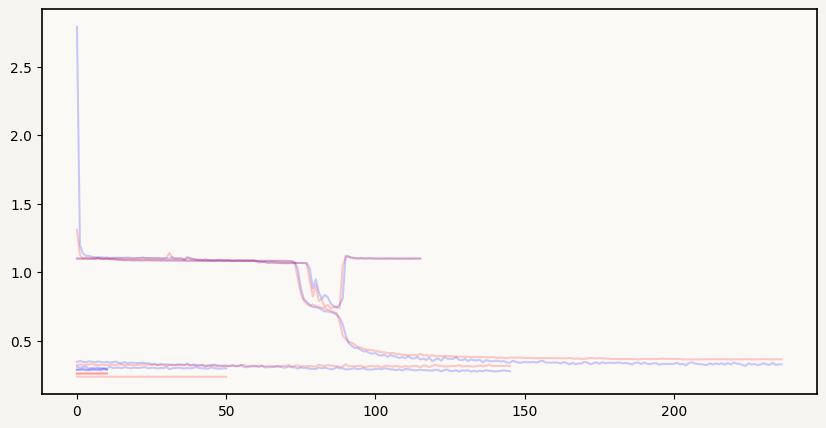

In [ ]:
# def plot_training_curves(train_curves=None, val_curves=None):
#     plt.figure(figsize=(10, 5))
    
#     # Plot each run with transparency
#     for i, (train_curve, val_curve) in enumerate(zip(train_curves, val_curves)):
#         plt.plot(train_curve, 'b-', alpha=0.2, label='Train' if i == 0 else "")
#         plt.plot(val_curve, 'r-', alpha=0.2, label='Val' if i == 0 else "")
#     # Calculate and plot means if multiple runs exist
#     if len(train_curves) > 1:
#         max_len = max(len(c) for c in train_curves)

#         # Pad curves with NaNs to uniform length
#         padded_train = np.array([curve + [np.nan]*(max_len-len(curve)) for curve in train_curves])
#         padded_val = np.array([curve + [np.nan]*(max_len-len(curve)) for curve in val_curves])
        
#         # Plot means
#         plt.plot(np.nanmean(padded_train, axis=0), 'b-', linewidth=2, label='Avg Train')
#         plt.plot(np.nanmean(padded_val, axis=0), 'r-', linewidth=2, label='Avg Val')
    
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Training Curves')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Call this when you want to see the plots
# plot_training_curves(train_curves=train_curve, val_curves=val_curve)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (80x4 and 3x127)

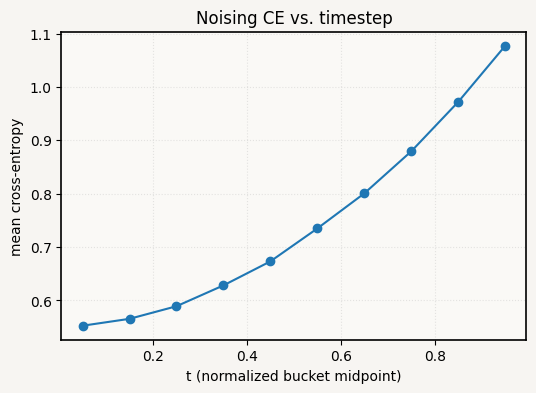

In [1039]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_noising_ce(clean: torch.Tensor,
                    noisy: torch.Tensor,
                    timesteps_norm: torch.Tensor,
                    num_buckets: int = 10):
    """
    clean:        (B, 1, d, n) one-hot tensor
    noisy:        (B, 1, d, n) noised tensor (can be thought of as logits)
    timesteps_norm: (B, 1) normalized to [0,1]
    num_buckets:  how many equal-width bins on [0,1]
    """
    B, _, d, n = clean.shape

    # convert one-hot → target indices (B, n)
    targets = clean.squeeze(1).argmax(dim=1)

    # flatten timesteps to (B,)
    t = timesteps_norm.squeeze(1)

    # build bucket edges [0,1]
    edges = torch.linspace(0.0, 1.0, num_buckets+1, device=t.device)
    bucket_ids = torch.bucketize(t, edges, right=False) - 1
    bucket_ids.clamp_(0, num_buckets-1)

    ce_per_bucket = []
    mids = []

    for b in range(num_buckets):
        mask = bucket_ids == b
        mids.append( (edges[b] + edges[b+1]).item() / 2 )

        if mask.sum() == 0:
            ce_per_bucket.append(float('nan'))
            continue

        # select noisy logits and targets for this bucket
        # noisy[mask] → (Kb,1,d,n) → squeeze→(Kb,d,n) → permute→(Kb,n,d) → reshape→(Kb*n, d)
        logits = (noisy[mask]
                  .squeeze(1)
                  .permute(0,2,1)
                  .reshape(-1, d))
        tgt    = targets[mask].reshape(-1)

        ce = F.cross_entropy(logits, tgt, reduction='mean').item()
        ce_per_bucket.append(ce)

    plt.figure(figsize=(6,4))
    plt.plot(mids, ce_per_bucket, marker='o')
    plt.xlabel("t (normalized bucket midpoint)")
    plt.ylabel("mean cross-entropy")
    plt.title("Noising CE vs. timestep")
    plt.grid(alpha=0.3)
    plt.show()


# Example usage:
plot_noising_ce(data, noisy_data, timesteps, num_buckets=10)


In [ ]:
#DiffusionLM paper for reverse diffusion
#Implement diffusion, careful about proper implementation of the formula
#split losses into timestep zones (especcialy to track the early and more informative samples)
#implement the reverse diffusion
#!!!Mask elements of the dataset to make the structure not complete. Moreover one could make
#the children/synonims choosing process not uniform to add complexity
#the size of the dataset is crucial, one should stay in 5-10K out of 65K to avoid memorization
#Check if the reconstructed samples from the reverse process are valid sequences, one can do it with 
#simple deterministc dynamic programming algortihm that checks if the sequence is valid
#Moreover, measure the distance between eleemnts of the dataset and the reconstructed ones
#one can use the overlap of character. 

#retry exponential scheduler even if it's fast in corrupting
#Manually recheck the diffusion process
#Verify manually selecting timesteps and running the reverse diffusion, check when it breaks. If it does it's training else it's diffusion.
#denoise until t!=0 >0 to check if in the very early steps, to see if there's asymptotic issues


![Screenshot 2025-03-22 alle 15.44.32.png](<attachment:Screenshot 2025-03-22 alle 15.44.32.png>)
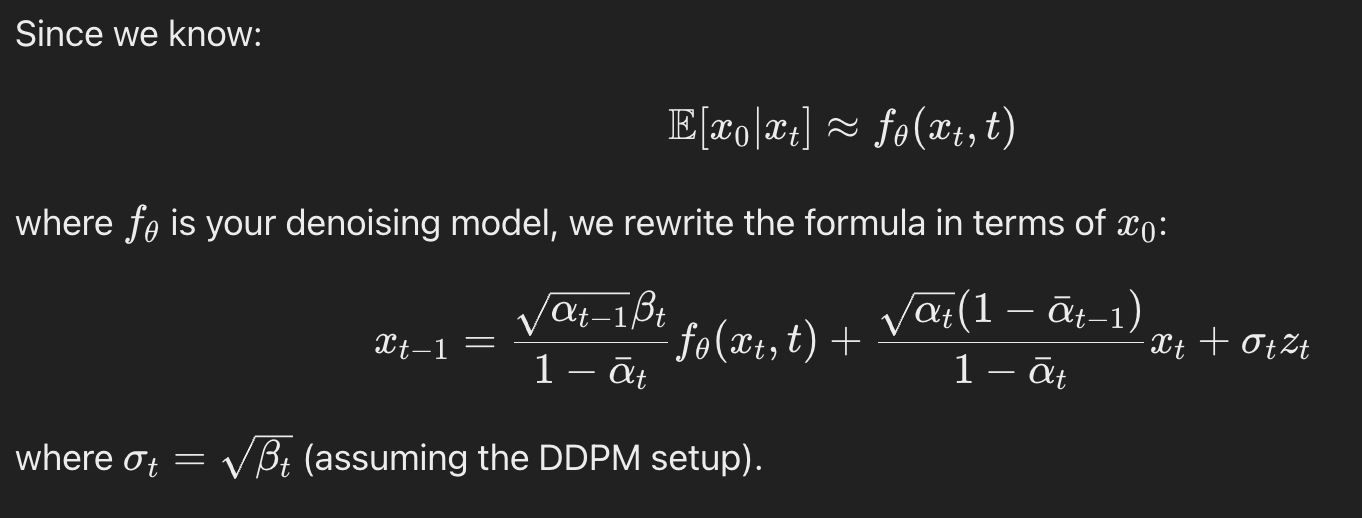

In [1092]:
a = model.forward(clean_filtered, timesteps_filtered)
a = torch.softmax(a, dim=2)
for i in range(10):
    print(a[i][0])
    print(clean_filtered[i][0])
    print(timesteps_filtered[i][0])

tensor([[1.1248e-05, 9.9999e-01, 1.2300e-06, 2.7046e-06, 1.5541e-06, 5.0229e-06,
         9.9999e-01, 7.4014e-06],
        [2.3382e-07, 9.2334e-06, 1.0000e+00, 2.9415e-06, 1.0000e+00, 7.6125e-07,
         5.3966e-06, 6.3782e-07],
        [9.9999e-01, 5.5857e-06, 2.4659e-07, 9.9999e-01, 7.8508e-07, 9.9999e-01,
         7.7097e-06, 9.9999e-01]], grad_fn=<SelectBackward0>)
tensor([[0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.]])
tensor(0.0936)
tensor([[9.9999e-01, 3.3476e-06, 9.6500e-07, 9.9999e-01, 1.8808e-06, 1.2179e-06,
         9.9999e-01, 4.7337e-06],
        [6.0277e-06, 4.5123e-07, 1.0000e+00, 4.0822e-06, 1.0655e-06, 1.0000e+00,
         4.8805e-06, 3.5834e-07],
        [5.0394e-06, 1.0000e+00, 3.0786e-07, 1.9226e-06, 1.0000e+00, 8.0616e-07,
         4.8392e-06, 9.9999e-01]], grad_fn=<SelectBackward0>)
tensor([[1., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1.,

In [1052]:
a_bar_T = diffusion.alpha_bar(torch.tensor([diffusion.max_time])).item()
print("a_bar_T:", a_bar_T)
sigma_T = math.sqrt(1 - a_bar_T) * diffusion.noise_scale  # ≈ 1 * 0.3 = 0.3
x_T = torch.randn_like(data[:100]) * sigma_T


a_bar_T: 1.910685465164705e-15


0.5

In [142]:
x_T = torch.randn(data.shape[0], 1, d, n) * diffusion.noise_scale # (B, 1, d, n)
t_norm = torch.ones(data.shape[0], 1)   # i.e. t = max_time → t_norm = 1

b = reverse_diffusion(
        model          = model,
        x_T  = x_T[:100],
        t_norm = torch.ones_like(timesteps[:100]),
        diffusion      = diffusion,
        T              = 300
    )

In [1053]:
x_T = torch.randn(data.shape[0], 1, d, n) * diffusion.noise_scale # (B, 1, d, n)
t_norm = torch.ones(data.shape[0], 1)   # i.e. t = max_time → t_norm = 1

b = reverse_diffusion(
        model          = model,
        x_T  = x_T[:100],
        t_norm = torch.ones_like(timesteps[:100]),
        diffusion      = diffusion,
        T              = 300
    )

In [1059]:
b[2][0]

tensor([[1.0000e+00, 4.9046e-07, 4.3403e-08, 9.7042e-08, 5.3542e-07, 2.5733e-07,
         4.0876e-07, 3.3472e-06],
        [5.4535e-07, 1.0000e+00, 4.4670e-08, 3.0329e-08, 1.0000e+00, 2.2833e-08,
         1.6470e-08, 1.0000e+00],
        [1.7700e-06, 1.9494e-08, 1.0000e+00, 1.0000e+00, 1.3093e-08, 1.0000e+00,
         1.0000e+00, 8.4938e-09]])

In [143]:
pred_labels = predict_labels(
    batch_logits = b,           # your (B,1,d,n) output (probs or logits)
    leaf_chars     = rules["terminal_symbols"],       # e.g. ['i','j','k','lù']
    prod_rules     = rules['rules'],
    branching_rate = branching_rate
)

In [144]:
pred_labels

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [416]:
labels.unique(return_counts=True)

(tensor([1, 2]), tensor([756, 706]))

In [ ]:
def build_inverse_map(prod_rules):
    """
    prod_rules: dict mapping parent_symbol -> list of (expansion_str, weight)
    returns: dict { (left_char, right_char) : parent_symbol }
    """
    inv = {}
    for parent, exp_list in prod_rules.items():
        for exp_str, _ in exp_list:
            # exp_str is e.g. "ij"
            if len(exp_str) != 2:
                continue
            left, right = exp_str[0], exp_str[1]
            inv[(left, right)] = parent
    return inv

# 2) tensor → string of leaf chars
def tensor_to_string(mat, index_to_char):
    """
    mat: (d, n) tensor of probs or one-hot
    index_to_char: dict { idx : char }
    """
    idxs = mat.argmax(dim=0)    # (n,)
    return ''.join(index_to_char[int(i)] for i in idxs)

# 3) collapse siblings until only the root remains
def recover_root(seq, inv_map, branching_rate=2):
    """
    seq: string of leaf chars, e.g. "ikjlfehp"
    inv_map: from build_inverse_map
    returns: root symbol as an int (1 or 2), or 0 if illegal
    """
    level = list(seq)
    while len(level) > 1:
        nxt = []
        for i in range(0, len(level), branching_rate):
            pair = (level[i], level[i+1])
            parent = inv_map.get(pair)
            if parent is None:
                return 0
            nxt.append(parent)
        level = nxt
    root = level[0]
    # assume root is '1' or '2'
    return int(root)

# 4) batch wrapper
def predict_labels(denoised_batch, leaf_chars, prod_rules, branching_rate=2):
    """
    denoised_batch: (B,1,d,n) logits or probs
    leaf_chars: list of chars in exactly the order you one-hot encoded them
    prod_rules: grammar['rules'] dictionary
    """
    inv_map = build_inverse_map(prod_rules)
    # build idx→char map
    index_to_char = {i: c for i, c in enumerate(leaf_chars)}

    B, _, d, n = denoised_batch.shape
    preds = []
    for b in range(B):
        mat = denoised_batch[b,0]           # (d,n)
        seq = tensor_to_string(mat, index_to_char)
        lbl = recover_root(seq, inv_map, branching_rate)
        preds.append(lbl)
    return torch.tensor(preds, dtype=torch.long)

In [ ]:

pred_labels = predict_labels(
    denoised_batch = x0_hat,           # your (B,1,d,n) output (probs or logits)
    leaf_chars     = leaf_chars,       # e.g. ['i','j','k','l']
    prod_rules     = rules['rules'],
    branching_rate = branching_rate
)

In [ ]:
pred_labels

tensor([2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 2, 0, 2, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0,
        1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 2, 0, 2, 2, 0, 0, 1,
        1, 0, 0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 1,
        0, 1, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0,
        0, 2, 1, 0, 2, 0, 0, 2])

In [ ]:
timesteps[:100]

tensor([[0.0646],
        [0.9418],
        [0.1272],
        [0.7794],
        [0.9307],
        [0.5367],
        [0.9128],
        [0.9637],
        [0.2352],
        [0.6173],
        [0.5170],
        [0.1830],
        [0.3403],
        [0.9559],
        [0.6369],
        [0.3651],
        [0.8021],
        [0.0543],
        [0.7343],
        [0.8550],
        [0.2737],
        [0.9475],
        [0.8743],
        [0.3079],
        [0.7443],
        [0.8556],
        [0.8090],
        [0.0607],
        [0.0161],
        [0.2460],
        [0.3528],
        [0.7785],
        [0.1870],
        [0.3925],
        [0.7778],
        [0.4937],
        [0.7958],
        [0.9866],
        [0.4013],
        [0.3048],
        [0.5359],
        [0.5642],
        [0.8878],
        [0.7429],
        [0.1951],
        [0.9623],
        [0.7889],
        [0.4557],
        [0.6223],
        [0.5362],
        [0.2618],
        [0.8157],
        [0.3829],
        [0.0875],
        [0.4562],
        [0

In [ ]:
pred_labels.unique(return_counts=True)

(tensor([0, 1, 2]), tensor([116,  45,  39]))

In [ ]:
print()

In [ ]:
print(pred_labels.shape, timesteps.squeeze(1).shape, labels.shape)

torch.Size([200]) torch.Size([1462]) torch.Size([1462])


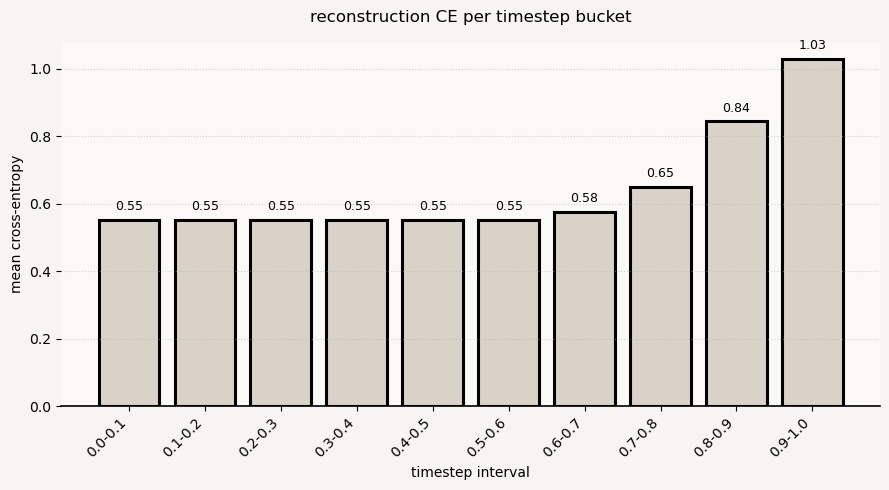

In [ ]:
import torch, torch.nn.functional as F
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl

# ──────────────────────────────────────────────────────────────────────────────
# INPUT
# ──────────────────────────────────────────────────────────────────────────────
# denoised_logits : (B, 1, d, n)  – model output  **raw logits**
# clean_onehot    : (B, 1, d, n)  – ground-truth one-hot matrices
# t_norm          : (B, 1) or (B, 1, 1)  – timesteps already normalised to [0,1]

device   = a.device                # CUDA or CPU
B, _, d, n = a.shape

# ──────────────────────────────────────────────────────────────────────────────
# 1.  token-level cross-entropy  →  per-sample CE
# ──────────────────────────────────────────────────────────────────────────────
logits = a.squeeze(1).transpose(1, 2)   # (B, n, d)
target = data.squeeze(1).argmax(1)           # (B, n) long

ce_token = F.cross_entropy(
    logits.reshape(-1, d),                           # (B·n, d)
    target.reshape(-1),                              # (B·n,)
    reduction="none"
).view(B, n)                                         # (B, n)

ce_per_sample = ce_token.mean(dim=1)                 # (B,)

# ──────────────────────────────────────────────────────────────────────────────
# 2.  bin timesteps into ten equal buckets
# ──────────────────────────────────────────────────────────────────────────────
t_used = timesteps.view(-1).to(device)                  # (B,)
edges  = torch.linspace(0.0, 1.0, 11, device=device) # 0.0, 0.1, … ,1.0
bin_id = torch.bucketize(t_used, edges, right=False) - 1   # (B,)

# average CE per bucket
ce_bar, count = [], []
for b in range(10):
    m   = bin_id == b
    cnt = int(m.sum())
    count.append(cnt)
    ce_bar.append(ce_per_sample[m].mean().item() if cnt else float("nan"))

df = pd.DataFrame({
    "t_min"  : [0.1*i     for i in range(10)],
    "t_max"  : [0.1*(i+1) for i in range(10)],
    "n_total": count,
    "CE"     : ce_bar
})

# ──────────────────────────────────────────────────────────────────────────────
# 3.  paper-style bar plot
# ──────────────────────────────────────────────────────────────────────────────
mpl.rcParams.update({
    "axes.facecolor"   : "#faf9f6",
    "figure.facecolor" : "#f7f5f2",
    "axes.edgecolor"   : "black",
    "axes.linewidth"   : 1.2,
    "grid.linestyle"   : ":",
    "grid.linewidth"   : 0.8,
    "grid.alpha"       : 0.5,
})

fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(df.index, df["CE"],
              color="#d8d2c8", edgecolor="black", linewidth=2.2)

ax.set_xticks(df.index)
ax.set_xticklabels([f"{a:.1f}-{b:.1f}" for a,b in zip(df.t_min, df.t_max)],
                   rotation=45, ha="right")
ax.set_xlabel("timestep interval")
ax.set_ylabel("mean cross-entropy")
ax.set_title("reconstruction CE per timestep bucket", pad=14)
ax.grid(axis="y")

for spine in ("top","right","left"): ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_linewidth(1.2)

for bar, val in zip(bars, df["CE"]):
    if not np.isnan(val):
        ax.text(bar.get_x()+bar.get_width()/2,
                bar.get_height()+0.02,
                f"{val:.2f}",
                ha="center", va="bottom", fontsize=9)

plt.tight_layout(); plt.show()


KeyError: 'accuracy'

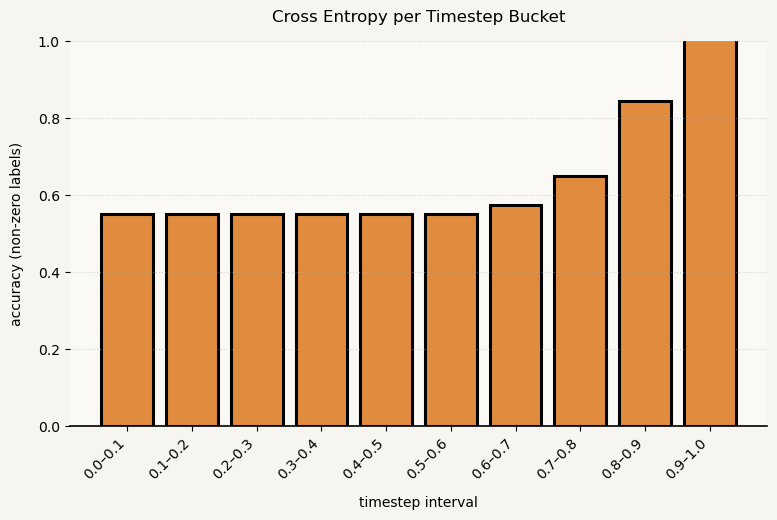

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_paperish(df: pd.DataFrame) -> None:
    """
    Bar plot of accuracy per timestep bucket, styled to match the
    ‘rainbow’ line plot (light background, gray grid, spines removed).
    """
    # ── colors & style ───────────────────────────────────────────────
    FIG_BG = "#f7f5f2"
    AX_BG  = "#faf9f6"
    BAR_FC = "#e08b3e"   # a warm orange‐brown
    BAR_EDGE = "black"

    mpl.rcParams.update({
        "axes.facecolor": AX_BG,
        "figure.facecolor": FIG_BG,
        "axes.edgecolor": "black",
        "axes.linewidth": 1.2,
        "grid.linestyle": ":",
        "grid.alpha": 0.5,
        "grid.linewidth": 0.8,
    })

    # ── figure & axis ────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(9, 5), facecolor=FIG_BG)
    ax.set_facecolor(AX_BG)

    # ── draw bars ────────────────────────────────────────────────────
    bars = ax.bar(
        df.index,
        df["CE"],
        color=BAR_FC,
        edgecolor=BAR_EDGE,
        linewidth=2.2,
    )

    # ── x‐ticks ───────────────────────────────────────────────────────
    ax.set_xticks(df.index)
    ax.set_xticklabels(
        [f"{a:.1f}–{b:.1f}" for a, b in zip(df.t_min, df.t_max)],
        rotation=45,
        ha="right",
    )

    # ── labels, title, limits ────────────────────────────────────────
    ax.set_xlabel("timestep interval", labelpad=10)
    ax.set_ylabel("accuracy (non-zero labels)", labelpad=10)
    ax.set_title(
        "Cross Entropy per Timestep Bucket",
        pad=14,
    )
    ax.set_ylim(0, 1.0)

    # ── grid & spines ─────────────────────────────────────────────────
    ax.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.5)
    for spine in ("top", "right", "left"):
        ax.spines[spine].set_visible(False)
    ax.spines["bottom"].set_linewidth(1.2)

    # ── annotate bar heights ─────────────────────────────────────────
    for bar, val in zip(bars, df["accuracy"]):
        if not np.isnan(val):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.02,
                f"{val:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

    plt.tight_layout()
    plt.show()

plot_paperish(df)



In [ ]:
o = torch.rand_like(data[:10])
o = reverse_diffusion(
    model          = model,
    noisy_image    = o,
    timesteps_norm = torch.tensor(1, device=o.device).unsqueeze(0),
    diffusion      = diffusion,
    T              = 300
)

In [ ]:
o.argmax(dim=2)
predict_labels(o, leaf_chars, rules['rules'], branching_rate)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
o

tensor([[[[0.0139, 0.9700, 0.0099, 0.0100, 0.0142, 0.9694, 0.0137, 0.0103],
          [0.9756, 0.0161, 0.0149, 0.0148, 0.9743, 0.0163, 0.9745, 0.0141],
          [0.0105, 0.0139, 0.9753, 0.9752, 0.0115, 0.0143, 0.0118, 0.9756]]],


        [[[0.7880, 0.8226, 0.0922, 0.5525, 0.7123, 0.3025, 0.2111, 0.6691],
          [0.6387, 0.3428, 0.8857, 0.3206, 0.9395, 0.4735, 0.7442, 0.8934],
          [0.2850, 0.3790, 0.0012, 0.9980, 0.9701, 0.0312, 0.8387, 0.6064]]],


        [[[0.6265, 0.2601, 0.9305, 0.6450, 0.4618, 0.3829, 0.5664, 0.5164],
          [0.7930, 0.6696, 0.4104, 0.0889, 0.9813, 0.4187, 0.1678, 0.4253],
          [0.7557, 0.4374, 0.1651, 0.2927, 0.7551, 0.2402, 0.6926, 0.2667]]],


        [[[0.0655, 0.5795, 0.8303, 0.1730, 0.2024, 0.8256, 0.3426, 0.0099],
          [0.4087, 0.0180, 0.8062, 0.1601, 0.6841, 0.9811, 0.3533, 0.8482],
          [0.0536, 0.4611, 0.1208, 0.8852, 0.0805, 0.3007, 0.5352, 0.0328]]],


        [[[0.7961, 0.9485, 0.4360, 0.8993, 0.4373, 0.8732, 0.7064, 0.494

In [ ]:
df

,t_min,t_max,n_total,CE
0,0.0,0.1,25,0.562289
1,0.1,0.2,27,0.563364
2,0.2,0.3,22,0.564927
3,0.3,0.4,24,0.566764
4,0.4,0.5,23,0.572101
5,0.5,0.6,28,0.606801
6,0.6,0.7,28,0.698237
7,0.7,0.8,24,0.855294
8,0.8,0.9,28,0.949897
9,0.9,1.0,27,1.063317


KeyError: 'accuracy'

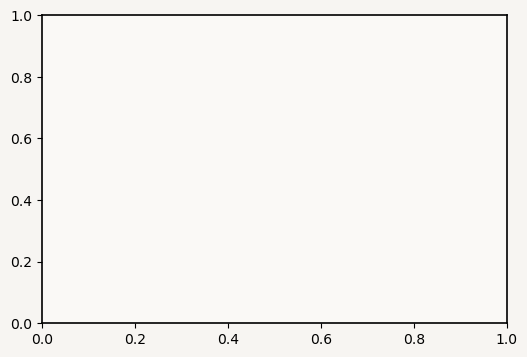

In [ ]:
import matplotlib.pyplot as plt

# assuming df has columns "t_min", "t_max", "n_total", "accuracy"
fig, ax = plt.subplots(figsize=(6,4))

# plot accuracy as a line or scatter
x = [(row.t_min + row.t_max) / 2 for _, row in df.iterrows()]
y = df["accuracy"]

ax.plot(x, y, marker="o", linestyle="-", label="accuracy")
ax.set_xlabel("timestep bin (midpoint)")
ax.set_ylabel("accuracy")
ax.set_title("accuracy per timestep bin")
ax.grid(True)
ax.legend()
plt.show()
        

KeyError: 'accuracy'

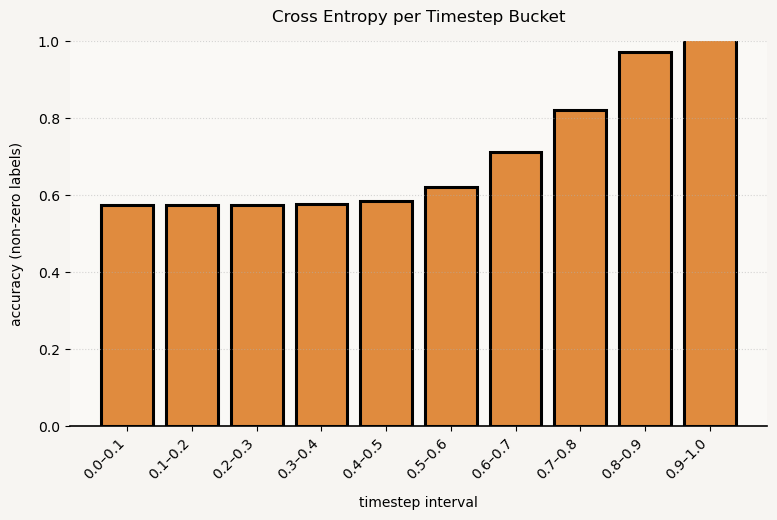

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_paperish(df: pd.DataFrame) -> None:
    """
    Bar plot of accuracy per timestep bucket, styled to match the
    ‘rainbow’ line plot (light background, gray grid, spines removed).
    """
    # ── colors & style ───────────────────────────────────────────────
    FIG_BG = "#f7f5f2"
    AX_BG  = "#faf9f6"
    BAR_FC = "#e08b3e"   # a warm orange‐brown
    BAR_EDGE = "black"

    mpl.rcParams.update({
        "axes.facecolor": AX_BG,
        "figure.facecolor": FIG_BG,
        "axes.edgecolor": "black",
        "axes.linewidth": 1.2,
        "grid.linestyle": ":",
        "grid.alpha": 0.5,
        "grid.linewidth": 0.8,
    })

    # ── figure & axis ────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(9, 5), facecolor=FIG_BG)
    ax.set_facecolor(AX_BG)

    # ── draw bars ────────────────────────────────────────────────────
    bars = ax.bar(
        df.index,
        df["CE"],
        color=BAR_FC,
        edgecolor=BAR_EDGE,
        linewidth=2.2,
    )

    # ── x‐ticks ───────────────────────────────────────────────────────
    ax.set_xticks(df.index)
    ax.set_xticklabels(
        [f"{a:.1f}–{b:.1f}" for a, b in zip(df.t_min, df.t_max)],
        rotation=45,
        ha="right",
    )

    # ── labels, title, limits ────────────────────────────────────────
    ax.set_xlabel("timestep interval", labelpad=10)
    ax.set_ylabel("accuracy (non-zero labels)", labelpad=10)
    ax.set_title(
        "Cross Entropy per Timestep Bucket",
        pad=14,
    )
    ax.set_ylim(0, 1.0)

    # ── grid & spines ─────────────────────────────────────────────────
    ax.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.5)
    for spine in ("top", "right", "left"):
        ax.spines[spine].set_visible(False)
    ax.spines["bottom"].set_linewidth(1.2)

    # ── annotate bar heights ─────────────────────────────────────────
    for bar, val in zip(bars, df["accuracy"]):
        if not np.isnan(val):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.02,
                f"{val:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

    plt.tight_layout()
    plt.show()

plot_paperish(df)

